In [29]:
import json
import os
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm


In [30]:
def read_geojson(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

def extract_infrastructure_ids(geojson_data):
    ids = []
    for feature in geojson_data['features']:
        # Assuming 'infrastructure_id' is the correct key in the properties
        id = feature['properties'].get('infrastructure_id')
        type = feature['properties'].get('infrastructure_type')
        if id is not None and type == 'Bus Only Lane':
            ids.append(id)
    return ids

# Usage
filename = 'District 7.geojson'
geojson_data = read_geojson(filename)
infrastructure_ids = extract_infrastructure_ids(geojson_data)
print(infrastructure_ids)


['metro_orange_line', 'ventura_blvd_bus_lanes', 'Lincoln Blvd Bus Lane', 'wilshire_blvd_2', 'santa_monica_blvd', 'la_brea_sunset_to_olympic', 'venice_blvd_bus_lane', 'sepulveda_blvd_bus_lane', 'flower_street_bus_lane', 'LAX Bus Lanes', 'florence_ave', 'figuera_street', '6th_street_bus_lane', '5th_street_bus_lane', 'n_alameda_street', 'east_aliso_bus_lane', 'sBX_green_line_BRT', 'sunset_bus_lane', 'La_loma_bus_lane', 'the_grand_ave_bus_lane', 'olive_ave_bus_lanes', 'alvarado_st_bus_lanes_south', 'alvarado_st_bus_lanes_north', 'E_hopitality_lane']


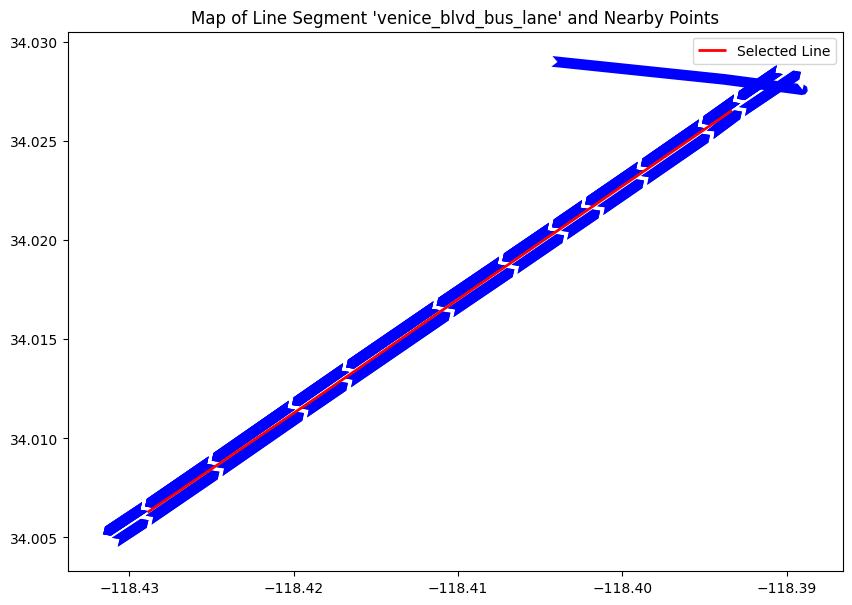

17155    80132
17345     6930
17346     6933
17347     6964
17348     6965
         ...  
19972    15273
19973    15317
19974    15286
19975    15282
19976    15278
Name: stop_id, Length: 73, dtype: object


In [31]:
def filter_and_map_by_proximity(line_geojson, points_geojson, infrastructure_id, keyword):
    # Miles 0.1 do degrees
    distance_degrees = 0.1 / 69

    # Load GeoJSON files
    lines_gdf = gpd.read_file(line_geojson)
    points_gdf = gpd.read_file(points_geojson)

    # Find the line with the given infrastructure_id
    line_filter = lines_gdf[lines_gdf['infrastructure_id'] == infrastructure_id]
    if line_filter.empty:
        print("No line found with the given infrastructure_id:", infrastructure_id)
        return None
    
    line = line_filter['geometry'].iloc[0]

    # Calculate proximity and filter points
    near_points = points_gdf[points_gdf['geometry'].apply(lambda x: line.distance(x) < distance_degrees)]
    # near_points = near_points[near_points['stop_name'].str.startswith(keyword, na=False)]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    line_filter.plot(ax=ax, color='red', linewidth=2, label='Selected Line')  # Plot only the selected line for clarity
    near_points.plot(ax=ax, color='blue', marker='o', markersize=5, label='Nearby Points')
    plt.legend()
    plt.title(f"Map of Line Segment '{infrastructure_id}' and Nearby Points")
    plt.show()

    return near_points

# Usage
line_geojson = 'District 7.geojson'
points_geojson = 'Speed Maps/1 November 2022/182_07_00–10_00_speeds.geojson'
infrastructure_id = 'venice_blvd_bus_lane'  # Ensure this ID is correct and exists in the GeoJSON file
nearby_points = filter_and_map_by_proximity(line_geojson, points_geojson, infrastructure_id, 'Venice')
print(nearby_points['stop_id'])


In [32]:
# import zipfile as zf
# files = zf.ZipFile("Speed Maps.zip", 'r')
# files.extractall('directory to extract')
# files.close()

In [33]:
alvarado_st_morning = ['4658', '4662', '4657', '4654', '3357', '3361', '3358', '3359', '5137']
alvarado_st_evening = ['11846', '10995', '11848', '5159', '13111', '15627', '13119', '13115', '13122']
venice_blvd_east = ['6923', '6939', '6935', '6931', '6928', '6914', '6902']
venice_blvd_west = ['15281', '15283', '15289', '15292', '15287', '15273']
# venice = venice_blvd_east + venice_blvd_west
venice = nearby_points['stop_id'].tolist()
alvarado = alvarado_st_morning + alvarado_st_evening

def parseFolder(folder_name, stops):
    speeds = {}
    variance = {}
    for geojson in os.listdir(folder_name):
        file_path = os.path.join(folder_name, geojson)
        features = filterGeojson(file_path, stops)
        time, type = extract_details(file_path)
        if type == "speeds":
            speeds[time] = getAverageSpeed(features)
        elif type == 'variance':
            variance[time] = getAverageVariation(features)
    print(folder_name)
    print('speed: ', speeds)
    print('variation: ', variance)
    return folder_name, speeds, variance

def extract_details(filename):
    filename = filename.split('/')[-1]
    parts = filename.replace('–', '_').replace('.', '_').split('_')
    start_hour = int(parts[1])
    end_hour = int(parts[3])
    start_time = f"{start_hour}am" if start_hour < 12 else f"{start_hour-12}pm"
    end_time = f"{end_hour}am" if end_hour < 12 else f"{end_hour-12}pm"
    time = f"{start_time} to {end_time}"
    word = parts[5]
    return time, word

def filterGeojson(file_path, stops):
    with open(file_path) as file:
        data = json.load(file)
    filtered_features = [feature for feature in data['features'] if feature['properties']['stop_id'] in stops]
    return filtered_features

def getAverageSpeed(features):
    speeds = []
    for feature in features:
        speeds.append(feature['properties']['p50_mph'])
    return sum(speeds) / len(speeds)

def getAverageVariation(features):
    variation = []
    for feature in features:
        variation.append(feature['properties']['p80_mph']-feature['properties']['p20_mph'])
    return sum(variation) / len(variation)


In [34]:
for dir in os.listdir("Speed Maps"):
    if not dir.startswith('.'):
        print(dir)
        print(parseFolder(os.path.join("Speed Maps", dir), alvarado))


4 July 2023
Speed Maps/4 July 2023
speed:  {'10am to 4pm': 8.49090909090909, '4pm to 7pm': 8.640909090909089, '7am to 10am': 9.318181818181818}
variation:  {'10am to 4pm': 5.081818181818183, '4pm to 7pm': 4.695454545454545, '7am to 10am': 4.8500000000000005}
('Speed Maps/4 July 2023', {'10am to 4pm': 8.49090909090909, '4pm to 7pm': 8.640909090909089, '7am to 10am': 9.318181818181818}, {'10am to 4pm': 5.081818181818183, '4pm to 7pm': 4.695454545454545, '7am to 10am': 4.8500000000000005})
6 September 2023
Speed Maps/6 September 2023
speed:  {'10am to 4pm': 8.677272727272726, '4pm to 7pm': 10.267741935483873, '7am to 10am': 8.691304347826087}
variation:  {'10am to 4pm': 4.877272727272727, '4pm to 7pm': 3.5870967741935487, '7am to 10am': 5.0608695652173905}
('Speed Maps/6 September 2023', {'10am to 4pm': 8.677272727272726, '4pm to 7pm': 10.267741935483873, '7am to 10am': 8.691304347826087}, {'10am to 4pm': 4.877272727272727, '4pm to 7pm': 3.5870967741935487, '7am to 10am': 5.06086956521739

In [ ]:
# Initialize a counter to keep track of each call to 'plot_combined_data'
call_counter = 0

def plot_combined_data(ax, title, speed, variation, bar_width=0.1):
    global call_counter  # Reference the global counter
    
    times = sorted(speed.keys())
    times.insert(0, times.pop())
    speeds = [speed[time] for time in times]
    variations = [variation.get(time, 0) for time in times]

    # Assuming you might have up to 10 different datasets, adjust the denominator as needed
    cmap = cm.get_cmap('viridis', 10)
    color = cmap(call_counter % 10)  # Use modulo to cycle through colors if more than 10 calls

    index = np.arange(len(times)) + call_counter * bar_width
    
    ax.bar(index, speeds, bar_width, label=title, color=color, yerr=variations, capsize=5)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Miles per Hour')
    ax.set_title('Comparison of Speed and Variation Across Time Spans')
    ax.set_xticks(index)
    ax.set_xticklabels(times, rotation=45)
    ax.legend(framealpha=1.0)


    call_counter += 1  # Increment the counter after each call

# Prepare the plot
fig, ax = plt.subplots()

# Loop through datasets (e.g., directories for different months)
for dir in sorted(os.listdir("Speed Maps")):
    if not dir.startswith('.'):
        title, speed, variation = parseFolder(os.path.join("Speed Maps", dir), venice)
        plot_combined_data(ax, title, speed, variation)

for i in range(0,3):
    ax.axvline((3*0.1)+i-0.05, color='red')

plt.tight_layout()
# plt.legend()
plt.show()


Speed Maps/1 November 2022
speed:  {'10am to 4pm': 12.928571428571425, '4pm to 7pm': 11.379310344827582, '7am to 10am': 13.578666666666669}
variation:  {'10am to 4pm': 6.953968253968256, '4pm to 7pm': 4.16206896551724, '7am to 10am': 6.669333333333331}
Speed Maps/2 April 2023
speed:  {'10am to 4pm': 12.7327868852459, '4pm to 7pm': 11.642352941176469, '7am to 10am': 13.964383561643837}
variation:  {'10am to 4pm': 6.722950819672132, '4pm to 7pm': 4.52823529411765, '7am to 10am': 7.434246575342466}
Speed Maps/3 May 2023
speed:  {'10am to 4pm': 12.854098360655737, '4pm to 7pm': 12.361176470588239, '7am to 10am': 13.732876712328768}
variation:  {'10am to 4pm': 6.373770491803277, '4pm to 7pm': 5.050588235294119, '7am to 10am': 6.826027397260275}
Speed Maps/4 July 2023
speed:  {'10am to 4pm': 12.505333333333335, '4pm to 7pm': 11.691919191919192, '7am to 10am': 14.164000000000003}
variation:  {'10am to 4pm': 5.12, '4pm to 7pm': 4.792929292929293, '7am to 10am': 7.193333333333333}


In [ ]:
def writeGeojson(data, out_path):
    new_geojson = {
    "type": "FeatureCollection",
    "features": data
    }
    
    # Write the new GeoJSON structure to a file
    with open(out_path, 'w') as file:
        json.dump(new_geojson, file)

# writeGeojson(june2023, "alvarado.geojson")

In [ ]:
# Initialize an empty DataFrame for the data
columns = ['Title', 'Time', 'Speed', 'Variation']
data_df = pd.DataFrame(columns=columns)

for dir in sorted(os.listdir("Speed Maps")):
    if not dir.startswith('.'):
        title, speed, variation = parseFolder(os.path.join("Speed Maps", dir), venice)
        data_tuples = [(time, speed[time], variation.get(time, None)) for time in sorted(speed)]
        temp_df = pd.DataFrame(data_tuples, columns=['Time', 'Speed', 'Variation'])
        temp_df['Title'] = title
        data_df = pd.concat([data_df, temp_df], ignore_index=True)

# Now, write the DataFrame to a CSV file
data_df.to_csv('speed_maps_data.csv', index=False)



In [ ]:
numericalDayToMonth = ['Nov 2022', 'Apr 2023', 'May 2023', 'July 2023', 'Aug 2023', 'Sept 2023', 'Nov 2023']

def extract_numerical_time(title):
    return int(title.split('/')[1].split(' ')[0])-1

# Add 'NumericalDay' column to the dataframe
data_df['NumericalDay'] = data_df['Title'].apply(extract_numerical_time)
data_df['Month'] = data_df['NumericalDay'].apply(lambda x: numericalDayToMonth[x])

# Split data based on the numerical day
before_data = data_df.loc[data_df['NumericalDay'] < 3]
after_data = data_df.loc[data_df['NumericalDay'] >= 3]

def analyze_trends(data, period_description, color='blue'):
    # Prepare data for regression
    X = data[['NumericalDay']]
    y_speed = data['Speed']
    y_variation = data['Variation']
    
    # Linear regression for speed
    model_speed = LinearRegression().fit(X, y_speed)
    speed_slope = model_speed.coef_[0]
    
    # Linear regression for variation
    model_variation = LinearRegression().fit(X, y_variation)
    variation_slope = model_variation.coef_[0]
    
    # Plotting the trends, including slope in the label
    plt.scatter(data['Month'], y_speed, color=color, label=f'Speed {period_description}')
    plt.plot(X.values, model_speed.predict(X), color=color, label=f'Speed Trend {period_description} (Slope: {speed_slope:.2f})')
    
    # plt.scatter(data['NumericalDay'], y_variation, color='green', label='Variation', alpha=0.5)
    # plt.plot(X, model_variation.predict(X), color='orange', label=f'Variation Trend (Slope: {variation_slope:.2f})')
    
    plt.title(f'Speed Trend Before and After Bus Lane Improvement')

    plt.legend()
    
    # Returning the slopes for further analysis if needed
    return speed_slope, variation_slope

# Now let's analyze the trends and display the slopes
plt.figure(figsize=(10, 5))
speed_slope_before, variation_slope_before = analyze_trends(before_data, "Before Bus Lane")
speed_slope_after, variation_slope_after = analyze_trends(after_data, "After Bus Lane", color='green')
plt.xlabel('Month Sampled')
plt.ylabel('Speed (mph)')
plt.show()

# Enhanced print statements to include the slope values
print(f"Before Implementation - Speed Trend: {'Increasing' if speed_slope_before > 0 else 'Decreasing'} (Slope: {speed_slope_before:.2f}), Variation Trend: {'Increasing' if variation_slope_before > 0 else 'Decreasing'} (Slope: {variation_slope_before:.2f})")
print(f"After Implementation - Speed Trend: {'Increasing' if speed_slope_after > 0 else 'Decreasing'} (Slope: {speed_slope_after:.2f}), Variation Trend: {'Increasing' if variation_slope_after > 0 else 'Decreasing'} (Slope: {variation_slope_after:.2f})")


In [ ]:
time_slots = before_data['Time'].unique()
for slot in time_slots:
    before = before_data[before_data['Time']==slot]
    after = after_data[after_data['Time']==slot]
    print('Speed', slot)
    print("Before:", before['Speed'].mean())
    print("After:", after['Speed'].mean())
    
    print('Variation',slot)
    print("Before:", before['Variation'].mean())
    print("After:", after['Variation'].mean())
    print()
before_data.head()

print('Overall')
print('Variation')
print("Before:", before_data['Variation'].mean())
print("After:", after_data['Variation'].mean())


In [ ]:
time_slots = before_data['Time'].unique()
for slot in time_slots:
    before = before_data[before_data['Time']==slot]
    after = after_data[after_data['Time']==slot]
    print(f"Analyzing trends for time slot: {slot}")
    speed_slope_before, variation_slope_before = analyze_trends(before, "Before Bus Lane")
    speed_slope_after, variation_slope_after = analyze_trends(after, "After Bus Lane")
    
    # Enhanced print statements to include the slope values
    print(f"Before Day 4 - Speed Trend: {'Increasing' if speed_slope_before > 0 else 'Decreasing'} (Slope: {speed_slope_before:.2f}), Variation Trend: {'Increasing' if variation_slope_before > 0 else 'Decreasing'} (Slope: {variation_slope_before:.2f})")
    print(f"Day 4 and After - Speed Trend: {'Increasing' if speed_slope_after > 0 else 'Decreasing'} (Slope: {speed_slope_after:.2f}), Variation Trend: {'Increasing' if variation_slope_after > 0 else 'Decreasing'} (Slope: {variation_slope_after:.2f})")


In [ ]:
# Assuming before_data and after_data are defined and have 'Time', 'Variation' columns
time_slots = before_data['Time'].unique().tolist()
time_slots.insert(0, time_slots.pop())  # Move the last item to the first position

# Set up the plotting area
fig, ax = plt.subplots(figsize=(8, 5))  # A single plot for variation differences

# Storage for percentage change calculations
variation_changes = []

# Iterate over each time slot to calculate and plot the percentage changes
for slot in time_slots:
    # Extract variation data for the current time slot
    before_variation = before_data[before_data['Time'] == slot]['Variation'].mean()
    after_variation = after_data[after_data['Time'] == slot]['Variation'].mean()
    
    # Calculate the percentage change in variation ((after - before) / before * 100)
    if before_variation != 0:  # To avoid division by zero
        percentage_change = ((after_variation - before_variation) / before_variation) * 100
    else:
        percentage_change = 0  # Or handle appropriately if before_variation is 0
    
    variation_changes.append(percentage_change)

# Bar chart of percentage changes in variation
x = np.arange(len(time_slots))  # the label locations
ax.bar(x, variation_changes, color='purple', alpha=0.7, width=0.5)

# Add some text for labels, title and axes ticks
ax.set_ylabel('Percentage Change in Variation (%)')
ax.set_title('Percentage Change in Variation for Each Time Period')
ax.set_xticks(x)
ax.set_xticklabels(time_slots, rotation=45)
ax.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at zero for reference

# Display the plot
plt.tight_layout()
plt.show()
